In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

In [ ]:
root = '/content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/'

In [ ]:
df = pd.read_csv(root+'corrected/west_bengal.csv')
df['DATE']= pd.to_datetime(df['DATE'])
df.describe()

,AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%),RAIN_FALL(mm)
count,37986.000000,37986.000000,37986.000000,37986.000000,37986.000000
mean,17.097033,0.748586,772.302168,48.501975,79.912604
std,12.560400,0.685272,386.545716,30.677135,100.071925
min,-40.000000,0.000000,0.000000,0.000000,0.000000
25%,3.833333,0.000000,928.400000,23.433333,6.333333
50%,21.650000,0.675000,956.512500,57.445000,19.250000
75%,27.250000,1.300000,973.242143,74.372917,150.500000
max,31.700000,2.200000,1007.550000,88.700000,979.000000


Index(['DATE', 'AIR_TEMP(°C)', 'WIND_SPEED(m/s)', 'ATMO_PRESSURE(hpa)',
       'HUMIDITY(%)', 'RAIN_FALL(mm)'],
      dtype='object')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ef4c0c790>,
      dtype=object)

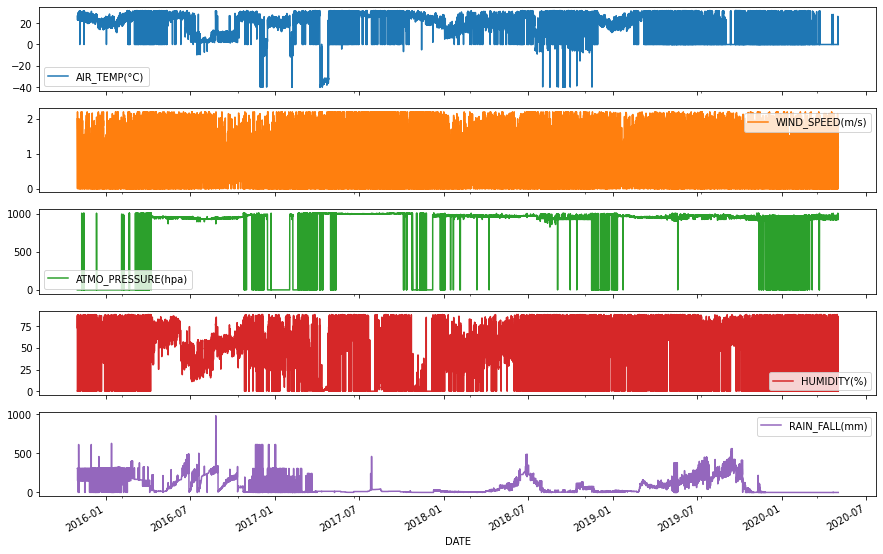

In [ ]:
print(df.columns)
df.set_index('DATE')[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True,figsize=(15, 10))

## Data split
Split the data into training and test set 

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
datelist = df['DATE']
print(datelist)
df = df.drop('DATE', 1)
training_set = df

0       2015-11-01 05:30:00
1       2015-11-01 06:30:00
2       2015-11-01 07:30:00
3       2015-11-01 08:30:00
4       2015-11-01 09:30:00
                ...        
37981   2020-04-30 23:30:00
37982   2020-05-01 00:30:00
37983   2020-05-01 01:30:00
37984   2020-05-01 02:30:00
37985   2020-05-01 03:30:00
Name: DATE, Length: 37986, dtype: datetime64[ns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
rain = training_set.iloc[:, 3]
rain

0         0.000000
1         0.000000
2        87.533333
3        83.966667
4        80.400000
           ...    
37981     0.000000
37982     0.000000
37983     0.000000
37984     0.000000
37985     0.000000
Name: HUMIDITY(%), Length: 37986, dtype: float64

In [ ]:
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set.iloc[:, 3:4])
# sc = MinMaxScaler(feature_range=(0, 1))
# training_set_scaled = sc.fit_transform(training_set)

array([[-1.58106728],
       [-1.58106728],
       [ 1.27234412],
       ...,
       [-1.58106728],
       [-1.58106728],
       [-1.58106728]])

In [ ]:
df_temp = pd.DataFrame(training_set_scaled)

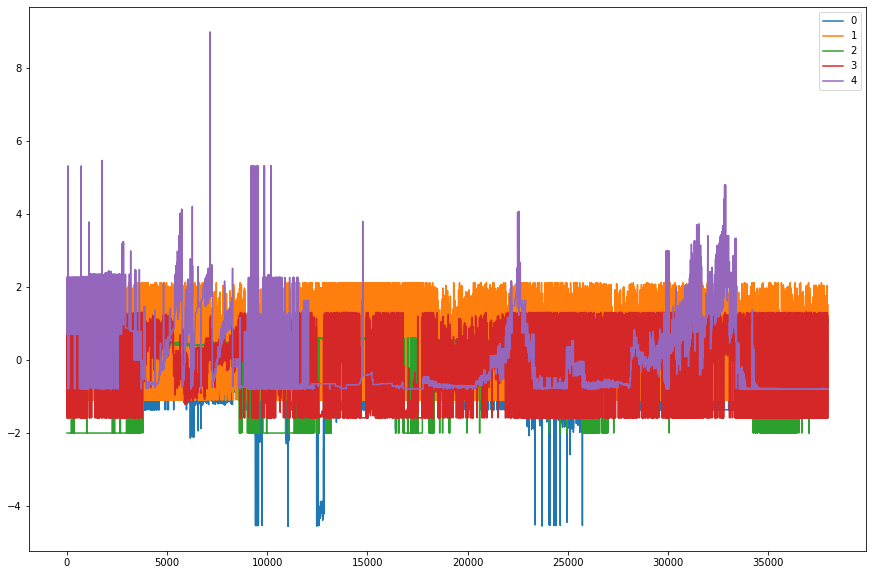

In [ ]:
df_temp.plot()

In [ ]:
print(training_set_scaled.shape)
print(df.shape)

(37986, 5)
(37986, 5)


In [ ]:
X_train = []
y_train = []

n_future = 1   
n_past = 60     

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 3])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (37926, 60, 5).
y_train shape == (37926, 1).


In [ ]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df.shape[1])))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,), loss='mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath= root+'all_predictions_humidity_wb_week5_lstm_isro.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=20, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=126)

Epoch 1/20
241/241 [==============================] - ETA: 0s - loss: 0.5405
Epoch 1: val_loss improved from inf to 0.75643, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/all_predictions_humidity_wb_week5_lstm_isro.h5
241/241 [==============================] - 12s 37ms/step - loss: 0.5405 - val_loss: 0.7564 - lr: 0.0010
Epoch 2/20
241/241 [==============================] - ETA: 0s - loss: 0.4096
Epoch 2: val_loss improved from 0.75643 to 0.72557, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/all_predictions_humidity_wb_week5_lstm_isro.h5
241/241 [==============================] - 7s 30ms/step - loss: 0.4096 - val_loss: 0.7256 - lr: 0.0010
Epoch 3/20
241/241 [==============================] - ETA: 0s - loss: 0.4000
Epoch 3: val_loss did not improve from 0.72557
241/241 [==============================] - 8s 33ms/step - loss: 0.4000 - val_loss: 0.7282 - lr: 0.0010
Epoch 4/20
241/241 [==============

In [ ]:
# model = tf.keras.models.load_model(root+'ISRO_MODEL/'+'isro.h5')

In [ ]:
# datelist_future = pd.date_range(datelist.iloc[-1], periods=90, freq='1d').tolist()
# predictions_future = model.predict(X_train[-90:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:
predictions_train.shape

(37866, 1)

In [ ]:
# y_pred_future = sc.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)
# y_pred_train = predictions_train
df['DATE'] = datelist

In [ ]:
y_pred_train

array([[59.046326],
       [54.692825],
       [47.736618],
       ...,
       [ 7.934551],
       [ 9.349574],
       [12.157214]], dtype=float32)

In [ ]:
# PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['AIR_TEMP(°C)', 'WIND_SPEED(m/s)', 'ATMO_PRESSURE(hpa)','HUMIDITY(%)', 'RAIN_FALL(mm)']).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['HUMIDITY(%)']).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))

In [ ]:
PREDICTION_TRAIN

,HUMIDITY(%)
DATE,
2015-11-06 10:30:00,59.046326
2015-11-06 11:30:00,54.692825
2015-11-06 12:30:00,47.736618
2015-11-06 13:30:00,47.665634
2015-11-06 14:30:00,45.583813
...,...
2020-04-30 23:30:00,7.691055
2020-05-01 00:30:00,7.366989
2020-05-01 01:30:00,7.934551


In [ ]:
PREDICTION_TRAIN.describe()

,HUMIDITY(%)
count,37866.000000
mean,49.400536
std,22.057646
min,0.168720
25%,35.480068
50%,55.873873
75%,67.725403
max,82.115959


In [ ]:
df.describe()

,AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%),RAIN_FALL(mm)
count,37986.000000,37986.000000,37986.000000,37986.000000,37986.000000
mean,17.097033,0.748586,772.302168,48.501975,79.912604
std,12.560400,0.685272,386.545716,30.677135,100.071925
min,-40.000000,0.000000,0.000000,0.000000,0.000000
25%,3.833333,0.000000,928.400000,23.433333,6.333333
50%,21.650000,0.675000,956.512500,57.445000,19.250000
75%,27.250000,1.300000,973.242143,74.372917,150.500000
max,31.700000,2.200000,1007.550000,88.700000,979.000000


In [ ]:
#Scaling up of data
for x in PREDICTION_TRAIN.columns:
  if(x == 'DATE'): 
    continue
  smin = df[x].min()
  smax = df[x].max()
  cmin = PREDICTION_TRAIN[x].min()
  cmax = PREDICTION_TRAIN[x].max()
  PREDICTION_TRAIN[x] = PREDICTION_TRAIN[x].apply(lambda x: smin + ((abs(x - cmin)/cmax)* (smax - smin + 1)))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7efb2d6ed0>,
      dtype=object)

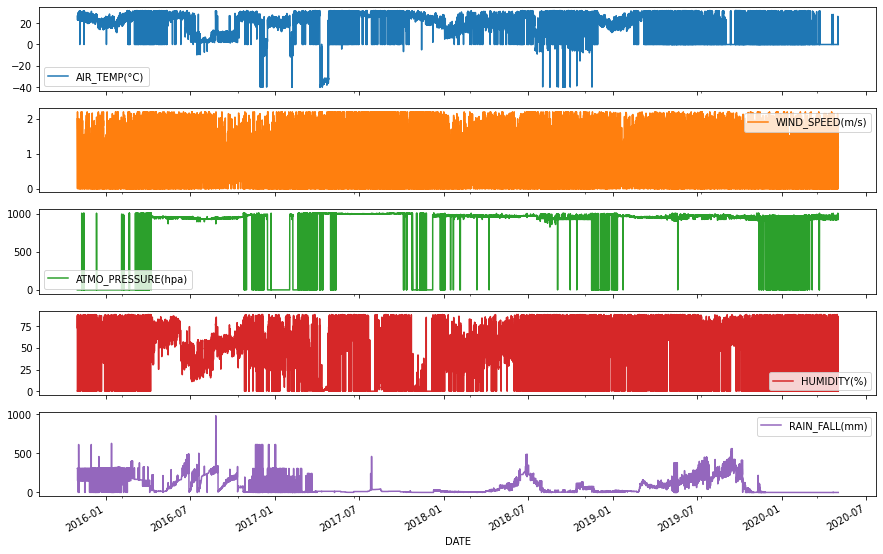

In [ ]:
df.set_index('DATE').plot(subplots=True, figsize=(15, 10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ef31b1190>],
      dtype=object)

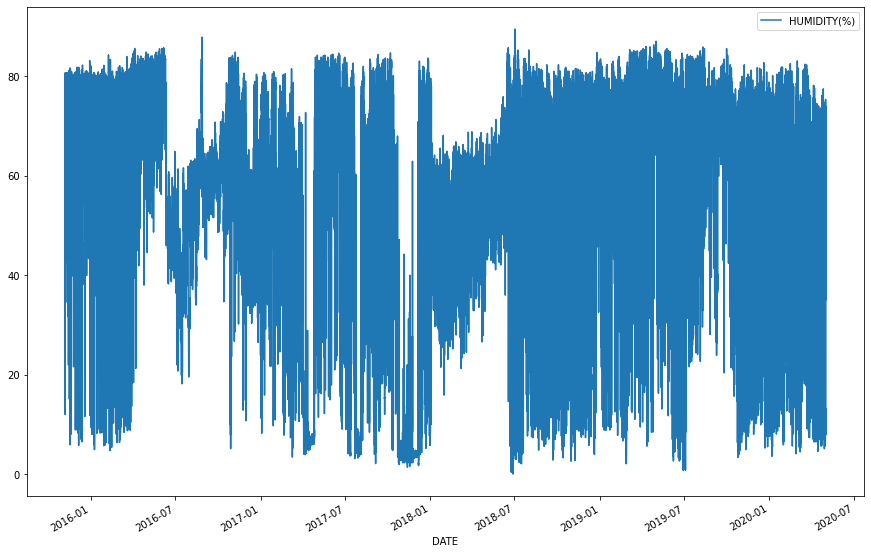

In [ ]:
PREDICTION_TRAIN.plot(subplots=True, figsize=(15, 10))

(37866,)
(37866,)


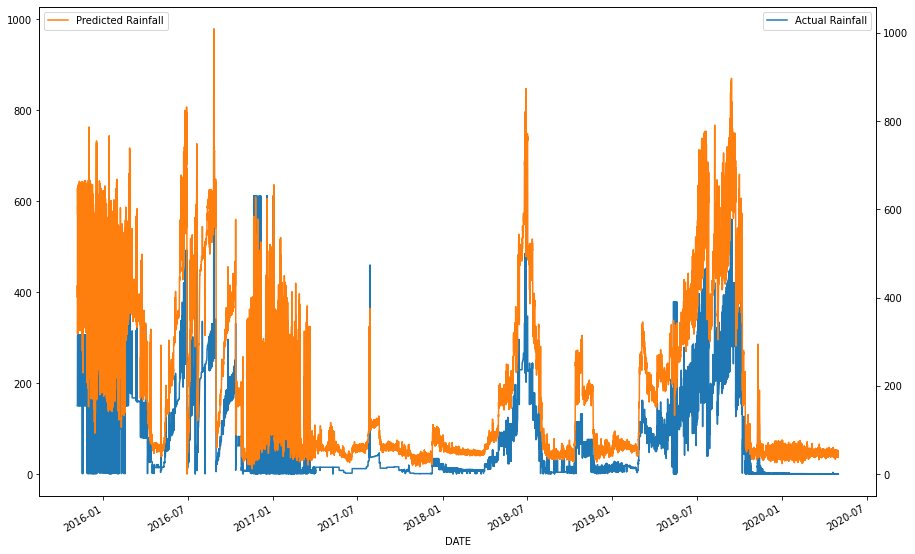

In [ ]:

print(df['RAIN_FALL(mm)'][2 * n_past + n_future -1:].shape)
print(PREDICTION_TRAIN['RAIN_FALL(mm)'].shape)
df.set_index('DATE')['RAIN_FALL(mm)'][2 * n_past + n_future -1:].plot()
plt.legend(['Actual Rainfall'])
PREDICTION_TRAIN['RAIN_FALL(mm)'].plot(secondary_y=True)
plt.legend(['Predicted Rainfall'],loc = 2)

In [ ]:
model.save(root+"ISRO_MODE/" + "HUMIDITY.h5")

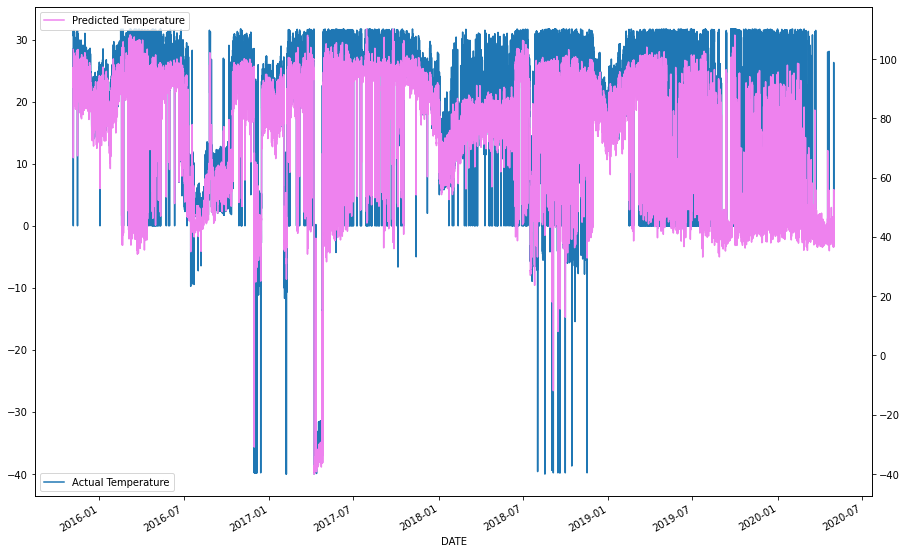

In [ ]:
df.set_index('DATE')['AIR_TEMP(°C)'][2 * n_past + n_future -1:].plot()
plt.legend(['Actual Temperature'])
PREDICTION_TRAIN['AIR_TEMP(°C)'].plot(secondary_y=True, color='violet')
plt.legend(['Predicted Temperature'],loc = 2)

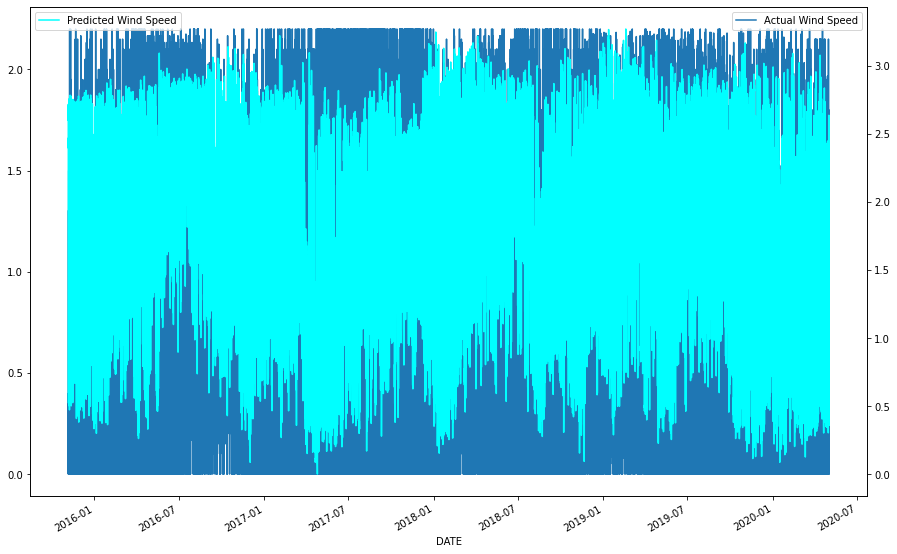

In [ ]:
df.set_index('DATE')['WIND_SPEED(m/s)'][2 * n_past + n_future -1:].plot()
plt.legend(['Actual Wind Speed'])
PREDICTION_TRAIN['WIND_SPEED(m/s)'].plot(secondary_y=True, color='cyan')
plt.legend(['Predicted Wind Speed'],loc = 2)

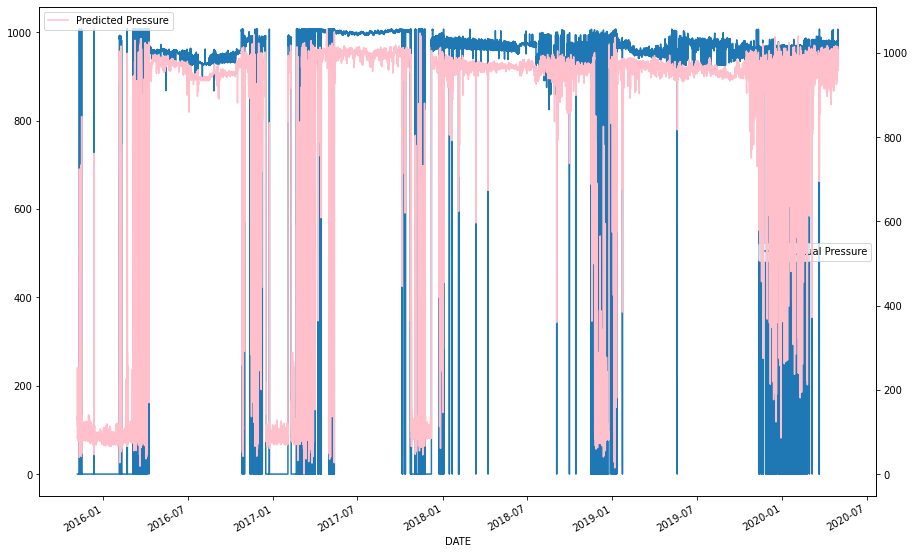

In [ ]:
df.set_index('DATE')['ATMO_PRESSURE(hpa)'][2 * n_past + n_future -1:].plot()
plt.legend(['Actual Pressure'])
PREDICTION_TRAIN['ATMO_PRESSURE(hpa)'].plot(secondary_y=True, color='pink')
plt.legend(['Predicted Pressure'],loc = 2)

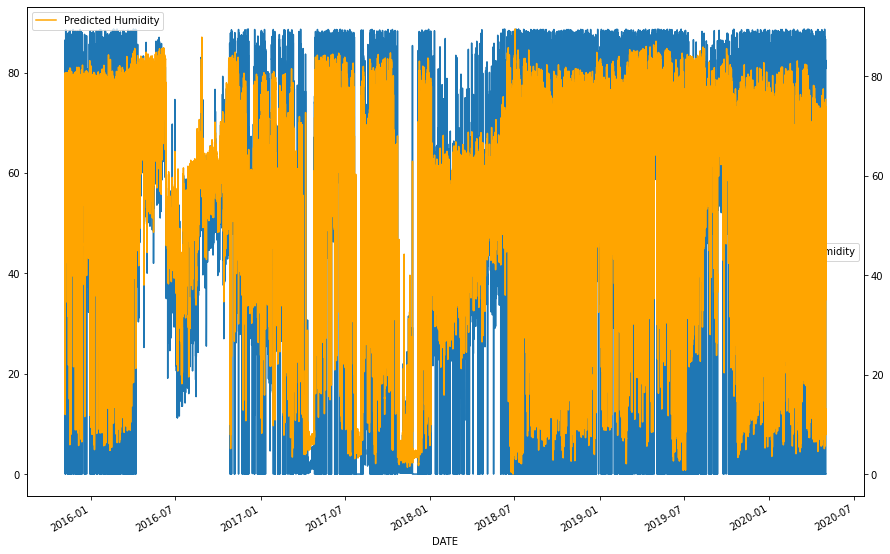

In [ ]:
df.set_index('DATE')['HUMIDITY(%)'][2 * n_past + n_future -1:].plot()
plt.legend(['Actual Humidity'])
PREDICTION_TRAIN['HUMIDITY(%)'].plot(secondary_y=True, color='orange')
plt.legend(['Predicted Humidity'],loc = 2)

In [ ]:
date_samples = datelist.sample(10)
date_samples

7236    2016-08-30 05:30:00
814     2015-12-05 13:30:00
34905   2019-12-12 11:30:00
22059   2018-06-08 13:30:00
30028   2019-05-18 04:30:00
8088    2016-10-04 17:30:00
37869   2020-04-25 23:30:00
760     2015-12-03 07:30:00
24893   2018-10-11 18:30:00
34649   2019-11-29 17:30:00
Name: DATE, dtype: datetime64[ns]

In [ ]:
df_samples = pd.DataFrame()

In [ ]:
for x in date_samples:
  print(PREDICTION_TRAIN.loc[x]['RAIN_FALL(mm)'])
  # print(df_input.loc[df_input['DATE'] == x]['RAIN_FALL(mm)'].tolist()[0])

In [ ]:
df_input.index

In [ ]:
(212 - 32)/100

In [ ]:

9/5